# Exploratory Data Analysis Part 2: Feature Engineering

In [1]:
# Libraries importing
import os
import joblib

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [2]:
# GLOBAL CONSTANTS
SEED = 1

In [3]:
# Read training data
data_dir = os.listdir('./data')[-1]
data = pd.read_csv(os.path.join('./data',
                                data_dir,
                                'preprocessed_data.csv'), index_col=0)

/tmp/ipykernel_1785/3461338438.py:3: DtypeWarning: Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(os.path.join('./data',


In [4]:
# Take a look on data inside the training dataset
data.head(10)

,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,STATE_OF_BIRTH,NACIONALITY,RESIDENCIAL_STATE,FLAG_RESIDENCIAL_PHONE,...,PROFESSIONAL_STATE,FLAG_PROFESSIONAL_PHONE,PROFESSIONAL_PHONE_AREA_CODE,MONTHS_IN_THE_JOB,PROFESSION_CODE,OCCUPATION_TYPE,PRODUCT,AGE,RESIDENCIAL_ZIP_3,TARGET_LABEL_BAD=1
0,,,,,,,,,,,,,,,,,,,,,
1,5,Web,1,F,6.0,1,RN,1,RN,Y,...,NO_JOB,N,NO_DATA,0,9.0,4.0,1,32,595,1
2,15,Carga,1,F,2.0,0,RJ,1,RJ,Y,...,NO_JOB,N,NO_DATA,0,11.0,4.0,1,34,230,1
3,5,Web,1,F,2.0,0,RN,1,RN,Y,...,NO_JOB,N,NO_DATA,0,11.0,NaN,1,27,591,0
4,20,Web,1,F,2.0,0,PE,1,PE,N,...,NO_JOB,N,NO_DATA,0,NaN,NaN,1,61,545,0
5,10,Web,1,M,2.0,0,RJ,1,RJ,Y,...,NO_JOB,N,NO_DATA,0,9.0,5.0,1,48,235,1
6,10,NaN,1,M,2.0,0,MG,1,MG,Y,...,MG,N,NO_DATA,0,9.0,2.0,2,40,371,1
7,15,Carga,1,F,2.0,2,BA,1,BA,Y,...,NO_JOB,N,NO_DATA,0,11.0,4.0,1,40,413,1
8,25,Web,1,F,1.0,0,MG,1,SP,N,...,SP,Y,5,0,11.0,2.0,1,28,686,0
9,15,NaN,1,F,1.0,0,SP,1,SP,Y,...,NO_JOB,N,NO_DATA,0,0.0,2.0,2,31,172,0


In [5]:
# Read the numerical and categorical features txt files
num_features = []
with open('./numerical_features_names.txt', 'r') as f:
    for line in f:
        # Read line by line and append top empty list
        num_features.append(line.split('\n')[0])

cat_features = []
with open('./categorical_features_names.txt', 'r') as f:
    for line in f:
        # Read line by line and append top empty list
        cat_features.append(line.split('\n')[0])

In [6]:
# Convert dtypes to the right ones
# First use suggested dtypes from pandas core
data = data.convert_dtypes()
# Remove Target variable from features
cat_features.remove('TARGET_LABEL_BAD=1')
# Then use the lists generated before
for col in cat_features:
    # First to string
    data[col] = data[col].astype('string')
    data[col] = pd.Categorical(data[col])

# As Pandas could introduce pd.NA values in some features
# when converting them to categorical, let's replace them with np.nan by casting
# int columns to float32
cols_to_float = data.select_dtypes(include='int').columns
data[cols_to_float] = data[cols_to_float].astype(dtype='float32')

##Dataset Split

In [7]:
# Split data into features and label
X, y = data.drop(columns=['TARGET_LABEL_BAD=1']), data['TARGET_LABEL_BAD=1']
# Split dataset into Train and Test
X_train_0, X_test, y_train_0, y_test = train_test_split(
    X, y, test_size=0.1, random_state=SEED
)
# Split train datasets into train and validation datasets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_0, y_train_0, test_size=0.1, random_state=SEED
)

In [8]:
## Build processing pipeline
# Create individual transformers
num_transformer = Pipeline(
        steps=[
            ('imputer' , SimpleImputer(strategy='median')),
            ('scaler'  , StandardScaler())
        ]
)

cat_transformer = Pipeline(
        steps=[
            ('imputer2', SimpleImputer(missing_values=pd.NA,
                                      strategy='most_frequent')),
            ('encoder' , OneHotEncoder(drop='if_binary',
                                       #dtype='int8',
                                       handle_unknown='ignore',
                                       sparse=False))
        ]
)

# Ensemble all the transformers
preprocessor = ColumnTransformer(
        transformers=[
            ('num' , num_transformer , num_features),
            ('cat' , cat_transformer , cat_features)
        ]
)

In [9]:
# Use ColumnTransformer 'preprocessor' to process data
# Train data
X_train_pre   = preprocessor.fit_transform(X=X_train)
X_train_0_pre = preprocessor.transform(X=X_train_0)
# Validation data
X_val_pre = preprocessor.transform(X=X_val)
# Test data
X_test_pre = preprocessor.transform(X=X_test)

/home/w/AnyOne_AI/cohort-02-2022/Final_Project/Credit-Risk-Analysis/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [16, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/w/AnyOne_AI/cohort-02-2022/Final_Project/Credit-Risk-Analysis/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [16, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/w/AnyOne_AI/cohort-02-2022/Final_Project/Credit-Risk-Analysis/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [4, 16, 19] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [10]:
# Save preprocessor to a file
joblib.dump(preprocessor, '../model/preprocessor.pkl')

['../model/preprocessor.pkl']

In [11]:
preprocessor_loaded = joblib.load('../model/preprocessor.pkl')

In [12]:
var = preprocessor_loaded.transform(X=X_train)

In [14]:
# Feature importance
import xgboost as xgb

# Load model
model = xgb.XGBClassifier()
model.load_model('../model/best_model.txt')

In [24]:
feat_imp = pd.Series(model.feature_importances_,
                     index=preprocessor.get_feature_names_out())

feat_imp

num__QUANT_DEPENDANTS           0.004013
num__MONTHS_IN_RESIDENCE        0.003243
num__PERSONAL_MONTHLY_INCOME    0.003958
num__OTHER_INCOMES              0.002668
num__PERSONAL_ASSETS_VALUE      0.003727
                                  ...   
cat__PAYMENT_DAY_10             0.010204
cat__PAYMENT_DAY_15             0.003605
cat__PAYMENT_DAY_20             0.002351
cat__PAYMENT_DAY_25             0.013569
cat__PAYMENT_DAY_5              0.005676
Length: 1096, dtype: float32

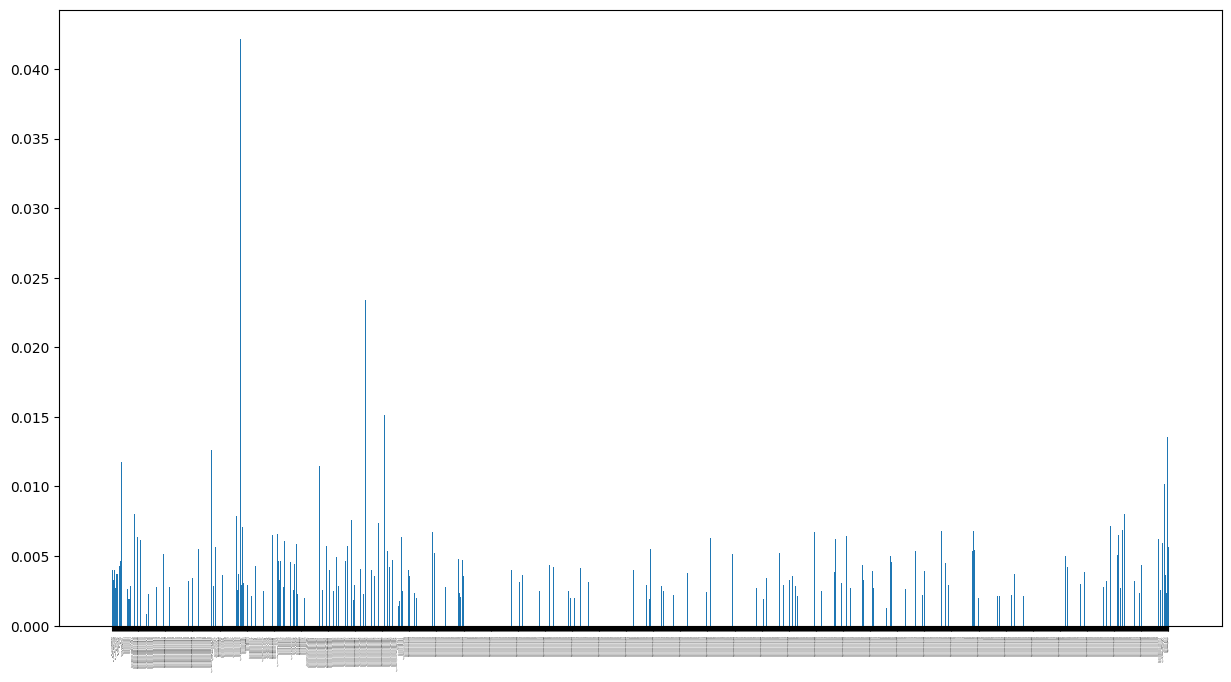

In [30]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 8))
plt.bar(feat_imp.index, height=feat_imp)
plt.xticks(rotation=90, fontsize=0.1)
plt.show()

In [70]:
# Save data for testing ml service
pd.DataFrame(X_train.iloc[0:1,:]).to_csv('../model/tests/test_entry.csv')

In [78]:
test_entry = pd.read_csv('../model/tests/test_entry.csv')

In [79]:
test = preprocessor.transform(test_entry)

/home/w/AnyOne_AI/cohort-02-2022/Final_Project/Credit-Risk-Analysis/FP_env/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0, 1, 2, 3, 5, 9, 10, 11, 16, 17, 18, 19, 20, 21, 23] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [80]:
model.predict_proba(test)[0,0]
# X_train_pre[0,:]

0.47992283

In [ ]:
# Save all datasets
np.savetxt(os.path.join('./data',
                        data_dir,
                        'X_train.csv'), X_train_pre, delimiter=',')
np.savetxt(os.path.join('./data',
                        data_dir,
                        'X_val.csv'), X_val_pre, delimiter=',')
np.savetxt(os.path.join('./data',
                        data_dir,
                        'X_test.csv'), X_test_pre, delimiter=',')
np.savetxt(os.path.join('./data',
                        data_dir,
                        'y_train.csv'), y_train, delimiter=',')
np.savetxt(os.path.join('./data',
                        data_dir,
                        'y_val.csv'), y_val, delimiter=',')
np.savetxt(os.path.join('./data',
                        data_dir,
                        'y_test.csv'), y_test, delimiter=',')

In [15]:
# Save features names after preprocessing
pd.Series(preprocessor.get_feature_names_out()).to_csv(
        os.path.join('./data',
                     data_dir,
                     'features_names_out.csv')
)